In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For date manipulation
from datetime import datetime

# For scaling and splitting data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For building a deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline


In [3]:
# Load the dataset
df = pd.read_csv("earthquake_1995-2023.csv")

# Display the first few rows
df.head()


,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN


In [4]:
# Check information on the dataset
print(df.info())

# Count missing values per column
print(df.isna().sum())

# Convert date_time to a datetime object; the format may be day-month-year hour:minute
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M", errors='coerce')

# See if the conversion worked correctly
df.head()

# Drop rows with NaT in date_time if any (or you might fill them)
df = df.dropna(subset=['date_time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      449 non-null    object 
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   object 
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
 16  location   994 non-null    object 
 17  continent  284 non-null    object 
 18  country    651 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 

In [5]:
# Extract year, month, day and hour from date_time for additional features.
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour

# For our example, we choose to predict the earthquake 'magnitude'
# We can drop columns that are not used for prediction.
# (We keep numeric features like depth, latitude, longitude, year, month, day, hour, and some fields that might be predictive.)
cols_to_drop = ['title', 'date_time', 'location']  # you can add more as needed

df_model = df.drop(columns=cols_to_drop)

# Some columns are categorical (e.g., 'magType', 'alert') – for simplicity, we will drop them.
# In a more advanced task you might encode them.
df_model = df_model.drop(columns=['alert', 'net','continent','country'])

# Check the cleaned dataframe
df_model.head()


,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,magType,depth,latitude,longitude,year,month,day,hour
0,6.5,7,4,0,657,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,2023,8,16,12
1,6.5,8,6,0,775,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,2023,7,19,0
2,6.6,7,5,0,899,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,2023,7,17,3
3,7.2,6,6,1,860,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,2023,7,16,6
4,7.3,0,5,1,820,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,2023,7,16,6


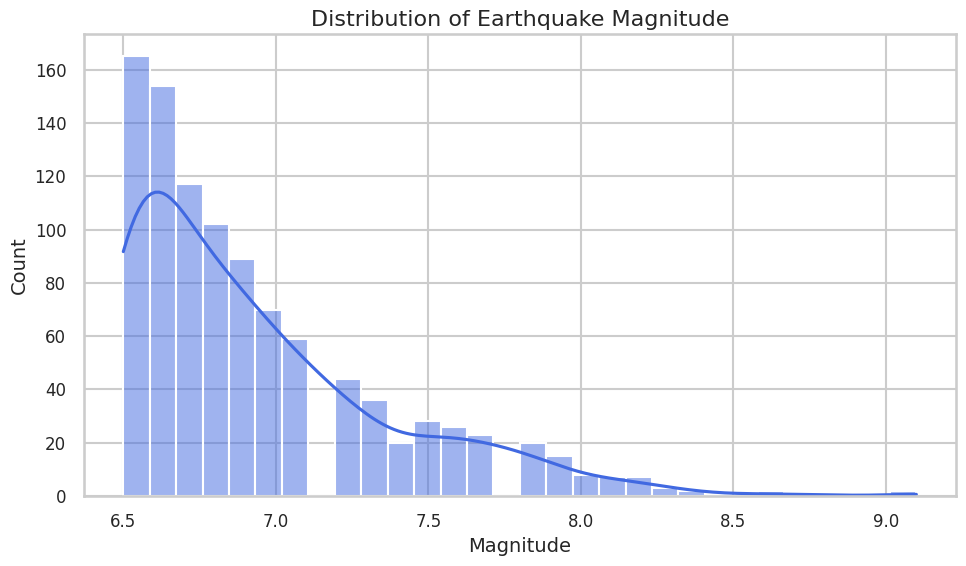

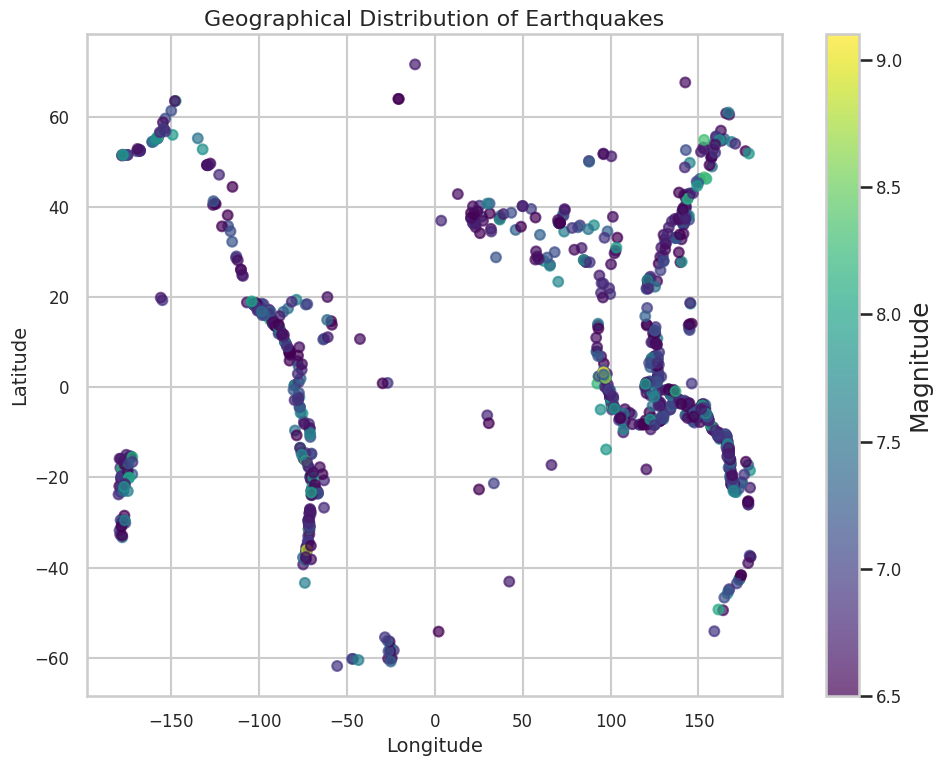

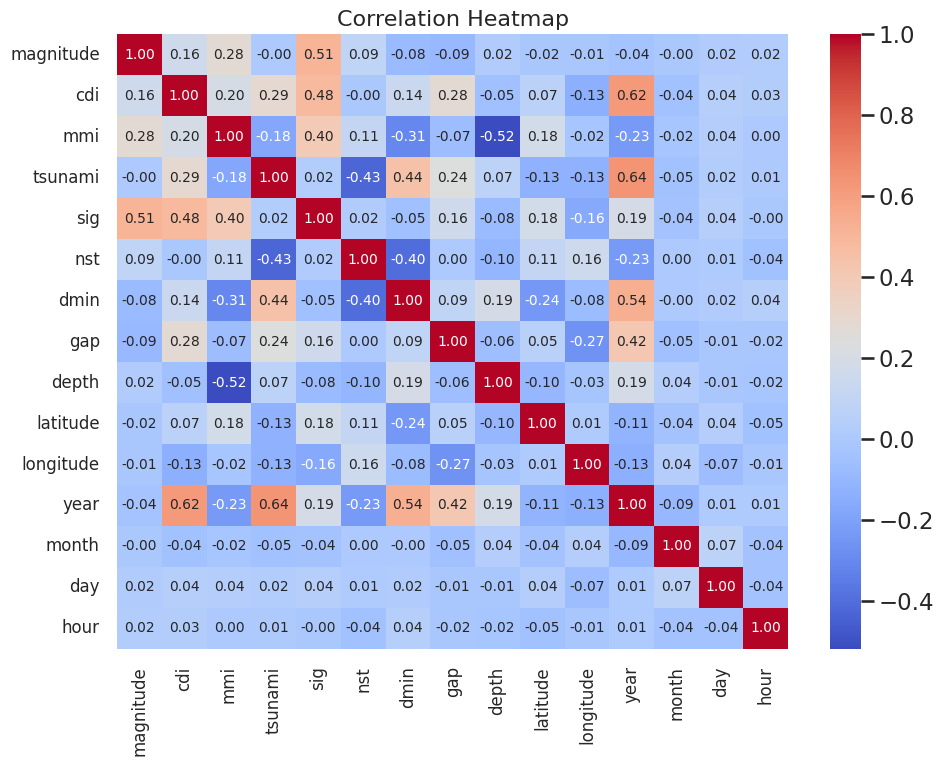

In [6]:
# Set seaborn style
sns.set(style='whitegrid', context='talk')

# -----------------------------------------
# 1. Histogram of earthquake magnitudes
plt.figure(figsize=(10,6))
sns.histplot(df['magnitude'], kde=True, bins=30, color='royalblue')
plt.title("Distribution of Earthquake Magnitude", fontsize=16)
plt.xlabel("Magnitude", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 2. Scatter plot: Latitude vs Longitude colored by magnitude
plt.figure(figsize=(10,8))
scatter = plt.scatter(df['longitude'], df['latitude'],
                      c=df['magnitude'], cmap='viridis', alpha=0.7, s=50)
cbar = plt.colorbar(scatter, label="Magnitude")
cbar.ax.tick_params(labelsize=12)
plt.title("Geographical Distribution of Earthquakes", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 3. Correlation heatmap of numeric features in the cleaned dataset
plt.figure(figsize=(10,8))
# Select only numeric columns for correlation calculation
numeric_df = df_model.select_dtypes(include=np.number)
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [7]:
# Define features and target.
# For this example, we use: cdi, mmi, tsunami, sig, nst, dmin, gap, depth, latitude, longitude, year, month, day, hour.
# (You may decide to include or exclude certain variables based on your domain knowledge.)
features = ['cdi', 'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'year', 'month', 'day', 'hour']
target = 'magnitude'

# Drop rows with missing values in our selected features and target:
df_model = df_model.dropna(subset=features + [target])

X = df_model[features].values
y = df_model[target].values

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize/scale the features (important for deep learning)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Create the deep neural network model using Keras Sequential API.
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)  # Regression output for magnitude
])

# Compile the model (using mean squared error loss for regression)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 50.3413 - mae: 6.8992 - val_loss: 46.2012 - val_mae: 6.7774
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47.2083 - mae: 6.7362 - val_loss: 44.3790 - val_mae: 6.6423
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.6560 - mae: 6.5430 - val_loss: 42.3639 - val_mae: 6.4889
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.2231 - mae: 6.3675 - val_loss: 40.1672 - val_mae: 6.3176
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.9178 - mae: 6.2055 - val_loss: 38.1421 - val_mae: 6.1547
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.8575 - mae: 5.9573 - val_loss: 35.4664 - val_mae: 5.9319
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.7559 - mae: 5.7468 - val_loss: 31.9176 - val_mae: 5.6215
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.0305 - mae: 5.4305 - val_loss: 28.2355 - val_mae: 5.2833
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

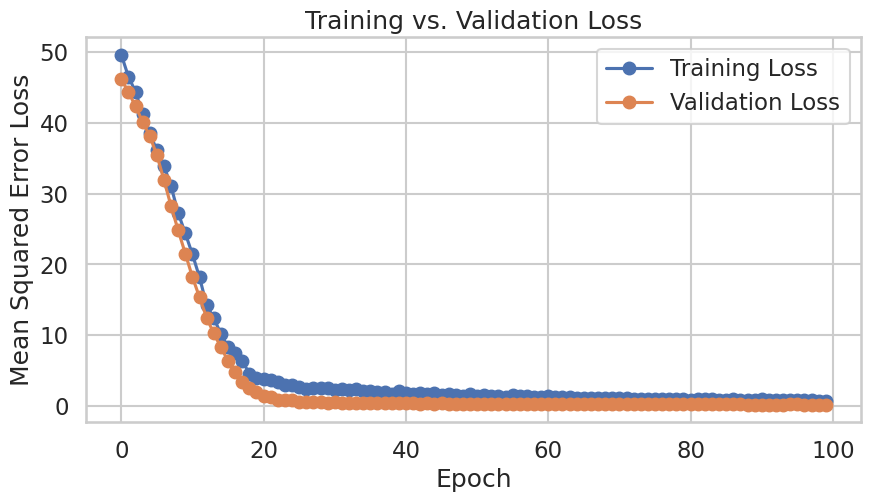

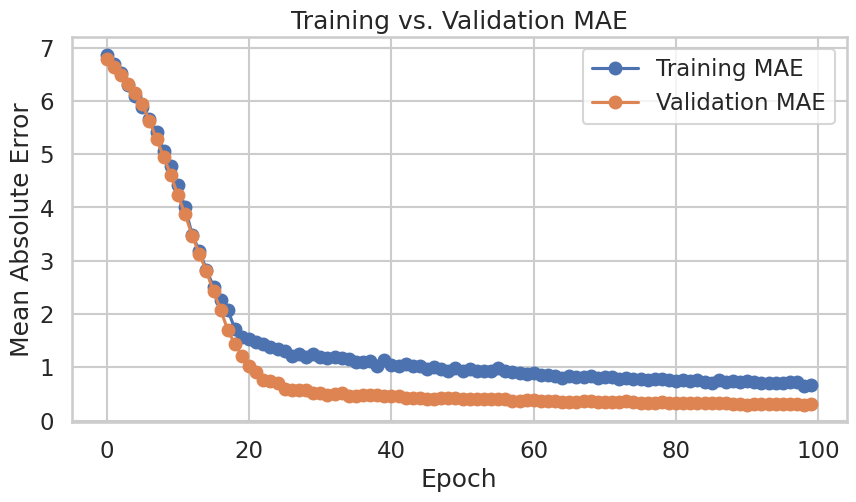

In [10]:
# Plot Loss vs. Epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# Plot Mean Absolute Error vs. Epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs. Validation MAE")
plt.legend()
plt.show()


In [11]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test MSE Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Additionally, calculate RMSE for interpretation
rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse:.4f}")


Test MSE Loss: 0.1649
Test MAE: 0.2892
Test RMSE: 0.4060


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


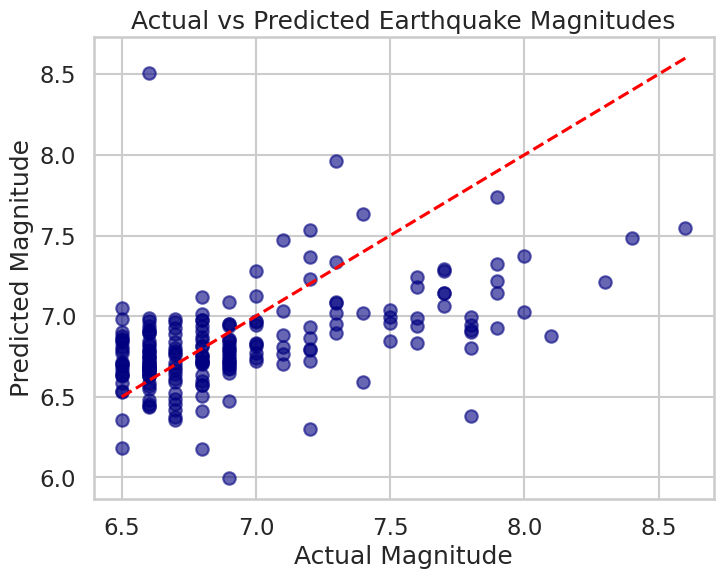

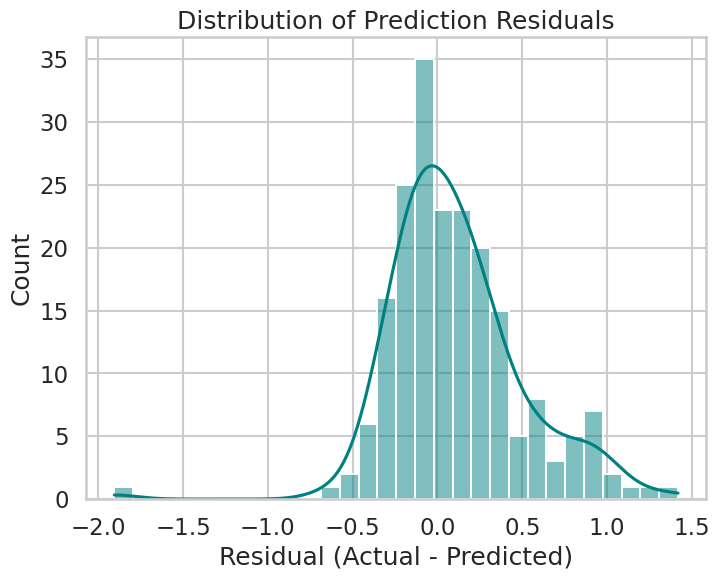

In [12]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled).flatten()

# Plot actual vs. predicted magnitudes
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='navy')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], ls="--", color='red')
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Actual vs Predicted Earthquake Magnitudes")
plt.show()

# A residual plot:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, color='teal', bins=30)
plt.title("Distribution of Prediction Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


In [13]:
model.save("earthquake_prediction_model.h5")
print("Model saved as earthquake_prediction_model.h5")


Model saved as earthquake_prediction_model.h5


In [17]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For interactive visualizations with Plotly
import plotly.express as px
import plotly.graph_objs as go

# For clustering to create a spatial feature
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For date-time manipulation
from datetime import datetime

# For deep learning & Keras Tuner (used for hyperparameter tuning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt  # requires pip install keras-tuner

# Read the dataset; change the file path as needed.
df = pd.read_csv("earthquake_1995-2023.csv")

# Convert the 'date_time' column into datetime objects.
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M", errors='coerce')
df = df.dropna(subset=['date_time'])
df = df.sort_values('date_time')

df.head()


<ipython-input-17-76ec17729f5c>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt  # requires pip install keras-tuner


,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
999,"M 7.1 - 14 km NE of Cabatuan, Philippines",7.1,1995-05-05 03:53:00,0,7,NaN,0,776,us,0,0.0,0.0,mw,16.0,12.626,125.297,"Cabatuan, Philippines",NaN,Philippines
998,"M 6.6 - 10 km W of Aianí, Greece",6.6,1995-05-13 08:47:00,0,9,NaN,0,670,us,0,0.0,0.0,mw,14.0,40.149,21.695,"Aianí, Greece",Europe,Greece
997,"M 6.9 - 27 km NNW of Maubara, Timor Leste",6.9,1995-05-14 11:33:00,0,6,NaN,0,732,us,0,0.0,0.0,mw,11.2,-8.378,125.127,"Maubara, Timor Leste",NaN,Indonesia
996,"M 7.7 - 249 km E of Vao, New Caledonia",7.7,1995-05-16 20:12:00,0,4,NaN,0,912,us,0,0.0,0.0,mw,20.2,-23.008,169.900,"Vao, New Caledonia",NaN,NaN
995,"M 7.1 - 85 km S of Tungor, Russia",7.1,1995-05-27 13:03:00,0,9,NaN,0,776,us,0,0.0,0.0,mwb,11.0,52.629,142.827,"Tungor, Russia",Asia,Russia


In [18]:
# Create a new column 'time_diff' (in hours) between subsequent earthquake events.
df['time_diff'] = df['date_time'].diff().dt.total_seconds() / 3600.0
df['time_diff'].fillna(0, inplace=True)  # replace the NaN for the first event with 0


<ipython-input-18-f5f53b81bea8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_diff'].fillna(0, inplace=True)  # replace the NaN for the first event with 0


In [19]:
# Perform clustering on the geographical coordinates:
coords = df[['latitude','longitude']]
kmeans = KMeans(n_clusters=5, random_state=42).fit(coords)
df['region_cluster'] = kmeans.labels_

# One-hot encode the region cluster labels:
df = pd.get_dummies(df, columns=['region_cluster'], prefix='region', drop_first=True)


In [20]:
# Ensure the date_time column is in datetime format.
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M", errors='coerce')

# Drop rows where conversion failed.
df = df.dropna(subset=['date_time'])

# Sort the data by date_time (if desired):
df = df.sort_values('date_time')

# Create time-based features: year, month, day, hour
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour

# Optionally, you can inspect the newly created columns:
print(df[['date_time', 'year', 'month', 'day', 'hour']].head())


              date_time  year  month  day  hour
999 1995-05-05 03:53:00  1995      5    5     3
998 1995-05-13 08:47:00  1995      5   13     8
997 1995-05-14 11:33:00  1995      5   14    11
996 1995-05-16 20:12:00  1995      5   16    20
995 1995-05-27 13:03:00  1995      5   27    13


In [21]:
# Set the sequence length – adjust as needed.
sequence_length = 5

# Choose features for the model.
base_features = ['cdi', 'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude',
                 'year', 'month', 'day', 'hour', 'time_diff']

# Add one-hot encoded region cluster columns.
# (If you already created 'region_cluster' and one-hot encoded it in df before, these should now be in df.)
region_cols = [col for col in df.columns if col.startswith('region_')]
features = base_features + region_cols

target = 'magnitude'

# Create a new DataFrame for modeling with only the required features.
df_model = df[features + [target]].dropna()

# (Optional) Scale the features for better training.
from sklearn.preprocessing import StandardScaler
scaler_features = StandardScaler()
df_model[features] = scaler_features.fit_transform(df_model[features])

# Now you can proceed with creating your time-series sequences.
def create_sequences(data, seq_length, feature_cols, target_col):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[feature_cols].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df_model, sequence_length, features, target)
print("Sequence shape:", X_seq.shape)  # (num_sequences, sequence_length, num_features)
print("Target shape:", y_seq.shape)


Sequence shape: (995, 5, 19)
Target shape: (995,)


In [22]:
def build_model(hp):
    model = Sequential()
    # First LSTM layer (tuning the number of units and dropout)
    model.add(LSTM(units=hp.Int("lstm_units_1", min_value=32, max_value=128, step=32),
                   activation='tanh',
                   return_sequences=True,
                   input_shape=(X_seq.shape[1], X_seq.shape[2])))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)))

    # Optionally add a second LSTM layer.
    if hp.Boolean("second_lstm"):
        model.add(LSTM(units=hp.Int("lstm_units_2", min_value=32, max_value=128, step=32),
                       activation='tanh'))
        model.add(Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)))

    # Fully connected layers
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # For regression output

    model.compile(optimizer=tf.keras.optimizers.Adam(
                        learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3)),
                  loss='mse',
                  metrics=['mae'])
    return model

# Instantiate the tuner.
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=5,
                        executions_per_trial=2,
                        directory='kt_dir',
                        project_name='earthquake_lstm')

# Run the hyperparameter search:
tuner.search(X_seq, y_seq, epochs=30, validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 5 Complete [00h 00m 26s]
val_loss: 10.081157207489014

Best val_loss So Far: 0.1540830209851265
Total elapsed time: 00h 02m 12s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 96)          │        44,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,757 (245.14 KB)

 Trainable params: 62,757 (245.14 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = best_model.fit(X_seq, y_seq, epochs=50, batch_size=32,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.5000 - mae: 0.5585 - val_loss: 0.1539 - val_mae: 0.3145
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3994 - mae: 0.5127 - val_loss: 0.1773 - val_mae: 0.3043
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3308 - mae: 0.4503 - val_loss: 0.2456 - val_mae: 0.3457
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3637 - mae: 0.4612 - val_loss: 0.1975 - val_mae: 0.3857
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3364 - mae: 0.4633 - val_loss: 0.1596 - val_mae: 0.3225
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3473 - mae: 0.4786 - val_loss: 0.5391 - val_mae: 0.6156
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3292 - mae: 0.4448 - val_loss: 0.3219 - val_mae: 0.4145
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3145 - mae: 0.4354 - val_loss: 0.1605 - val_mae: 0.3228
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.293

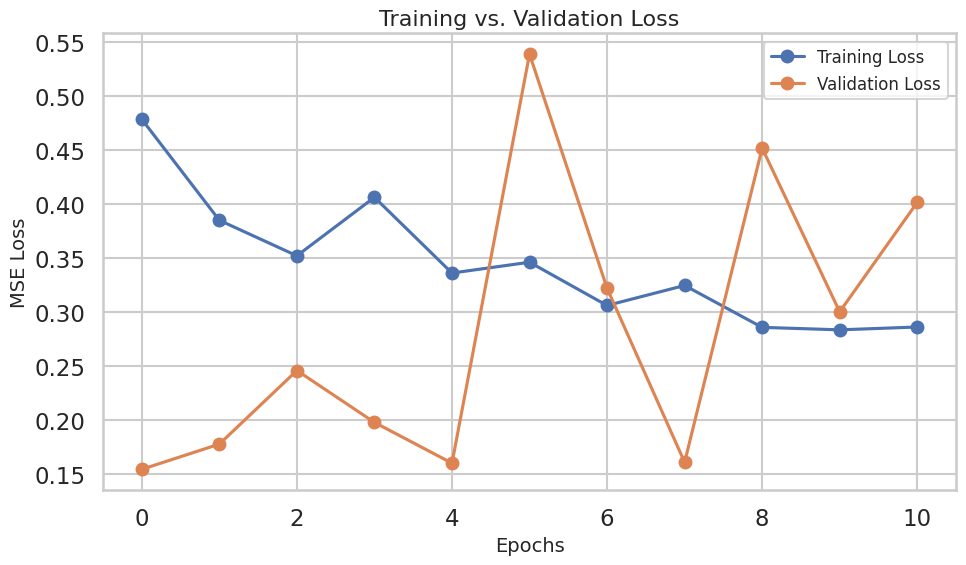

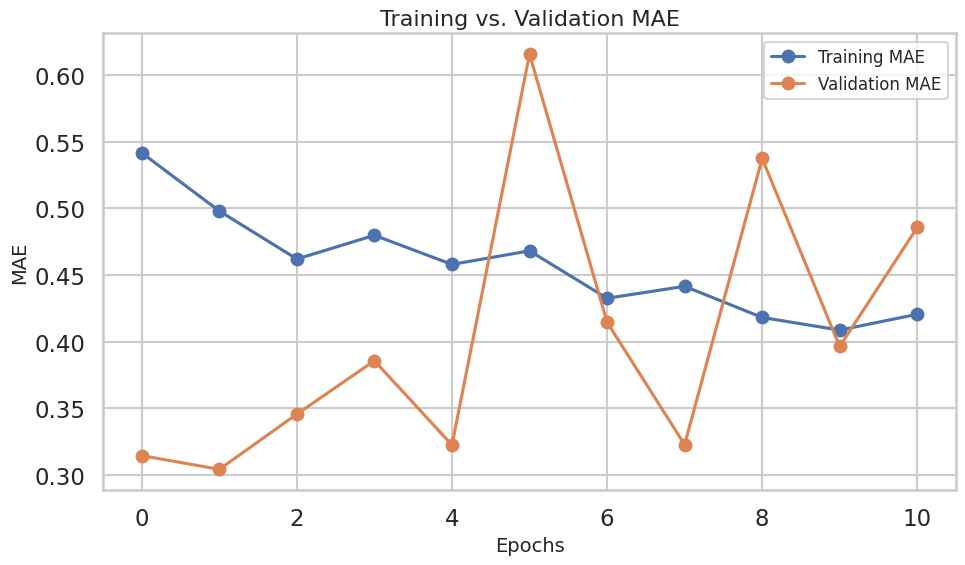

In [24]:
import matplotlib.pyplot as plt

# Plot Loss Curves
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("MSE Loss", fontsize=14)
plt.title("Training vs. Validation Loss", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot MAE Curves
plt.figure(figsize=(10,6))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.title("Training vs. Validation MAE", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [25]:
# Make predictions on the full sequence data (or use a held-out test set if desired)
y_pred = best_model.predict(X_seq).flatten()

# Create a scatter plot of actual vs predicted values using Plotly
import plotly.express as px

fig = px.scatter(x=y_seq, y=y_pred, labels={'x': 'Actual Magnitude', 'y': 'Predicted Magnitude'},
                 title="Actual vs Predicted Earthquake Magnitudes",
                 template="plotly_white")
# Diagonal line for reference
fig.add_trace(go.Scatter(x=[min(y_seq), max(y_seq)],
                         y=[min(y_seq), max(y_seq)],
                         mode='lines', name='Ideal', line=dict(color='red', dash='dash')))
fig.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [26]:
# Interactive Time-Series Plot: Earthquake magnitudes over time.
df_plot = df.copy()  # original df sorted by date_time
fig_ts = px.scatter(df_plot, x='date_time', y='magnitude', color='mmi', hover_data=['depth'],
                    title="Interactive Earthquake Magnitude Time Series",
                    labels={'date_time': 'Date', 'magnitude': 'Magnitude'})
fig_ts.update_traces(marker=dict(size=8))
fig_ts.update_layout(font=dict(size=14))
fig_ts.show()

# Interactive Map Plot: Geographical earthquake distribution.
fig_map = px.scatter_mapbox(df_plot, lat="latitude", lon="longitude",
                            hover_name="title",
                            hover_data=["magnitude", "depth", "time_diff"],
                            color="magnitude", size="magnitude",
                            color_continuous_scale=px.colors.cyclical.IceFire,
                            size_max=15, zoom=1,
                            title="Interactive Geographical Distribution of Earthquakes")
fig_map.update_layout(mapbox_style="open-street-map", font=dict(size=14))
fig_map.show()


In [27]:
def preprocess_new_sample(new_sample_df):
    """
    new_sample_df : a pandas DataFrame that contains the same raw columns
                    you used in your original dataframe (including date_time).
    Returns a preprocessed DataFrame containing the engineered features.
    """
    # Ensure the date_time column is converted
    new_sample_df['date_time'] = pd.to_datetime(new_sample_df['date_time'], format="%d-%m-%Y %H:%M", errors='coerce')

    # Sort if needed
    new_sample_df = new_sample_df.sort_values('date_time')

    # Create time-based features
    new_sample_df['year'] = new_sample_df['date_time'].dt.year
    new_sample_df['month'] = new_sample_df['date_time'].dt.month
    new_sample_df['day'] = new_sample_df['date_time'].dt.day
    new_sample_df['hour'] = new_sample_df['date_time'].dt.hour

    # Create time difference (here we assume the events are sorted and compute the delta in hours)
    new_sample_df['time_diff'] = new_sample_df['date_time'].diff().dt.total_seconds() / 3600.0
    new_sample_df['time_diff'].fillna(0, inplace=True)

    # (Optional) Add spatial cluster features if these were computed earlier –
    # if you have stored your kmeans model and performed one-hot encoding.
    # For example, if your kmeans model is available as "kmeans" and you want to one-hot encode:
    if 'region_cluster' not in new_sample_df.columns:
        new_sample_df['region_cluster'] = kmeans.predict(new_sample_df[['latitude', 'longitude']])
        new_sample_df = pd.get_dummies(new_sample_df, columns=['region_cluster'], prefix='region', drop_first=True)

    # Select only the features needed for the model
    # Use the same feature names created in your project
    base_features = ['cdi', 'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'gap', 'depth',
                     'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'time_diff']
    region_cols = [col for col in new_sample_df.columns if col.startswith('region_')]
    feat_list = base_features + region_cols

    return new_sample_df[feat_list]

def format_sequence(data, seq_length):
    """
    data : numpy array of shape (num_samples, num_features)
    seq_length : size of the sliding window.

    Returns a sequence of data ready to feed into the time-series model.
    """
    X_seq = []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
    return np.array(X_seq)

def predict_earthquake(new_sample_df, model, seq_length):
    """
    new_sample_df: pandas DataFrame containing new earthquake events with raw columns.
    model: a trained model ready for inference.
    seq_length: integer, the sequence length used during training.

    This function:
    - Applies preprocessing to the new sample DataFrame,
    - Converts the features to numpy array,
    - If needed formats the data as a sequence,
    - Returns predictions.
    """
    # Preprocess the new data
    processed = preprocess_new_sample(new_sample_df)

    # Scale the features using the saved scaler.
    processed_scaled = scaler_features.transform(processed.values)

    # Format the input as a sequence (if your model expects sequences)
    X_seq_new = format_sequence(processed_scaled, seq_length)

    # Make predictions; note: predictions will be one per sequence.
    predictions = model.predict(X_seq_new).flatten()

    return predictions

# Example usage:
# Suppose you have a new DataFrame new_df that follows the same structure as the original df:
# new_df = pd.read_csv("new_earthquake_data.csv")
# preds = predict_earthquake(new_df, best_model, sequence_length)
# print("Predicted magnitudes:", preds)


In [28]:
# Split time series data: 80% training, 20% test.
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print("Training sequence shape:", X_train.shape)
print("Test sequence shape:", X_test.shape)


Training sequence shape: (796, 5, 19)
Test sequence shape: (199, 5, 19)


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test set using your best model:
y_pred_test = best_model.predict(X_test).flatten()

# Calculate performance metrics:
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Test MSE:  {:.4f}".format(mse))
print("Test MAE:  {:.4f}".format(mae))
print("Test R²:   {:.4f}".format(r2))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test MSE:  0.4016
Test MAE:  0.4856
Test R²:   -1.6445


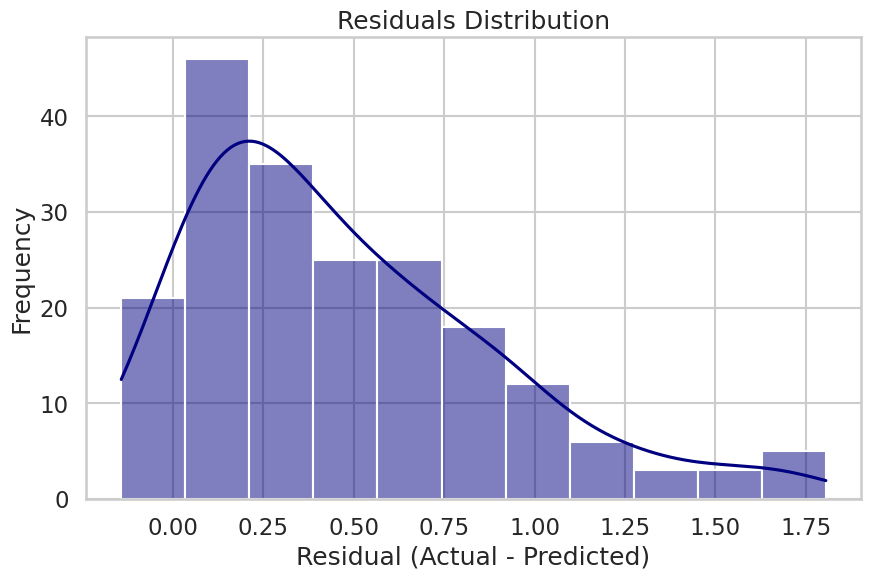

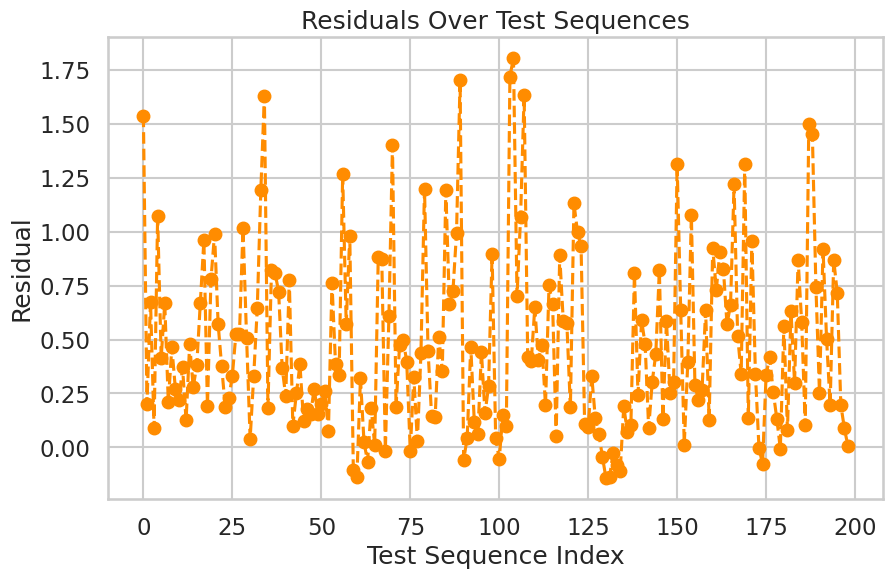

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred_test

# Plot residual histogram
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='navy')
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# Plot residuals over time (using the test set index)
plt.figure(figsize=(10,6))
plt.plot(residuals, marker='o', linestyle='--', color='darkorange')
plt.title("Residuals Over Test Sequences")
plt.xlabel("Test Sequence Index")
plt.ylabel("Residual")
plt.show()


In [31]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Assuming df is already your sorted dataframe with earthquake event data)

# --- Step 1: Ensure region_cluster exists ---
if "region_cluster" not in df.columns:
    # Use latitude and longitude to perform clustering.
    coords = df[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=5, random_state=42)
    # You can either use kmeans.fit_predict to directly assign labels:
    df['region_cluster'] = kmeans.fit_predict(coords)
    # Alternatively, you could use:
    # kmeans.fit(coords)
    # df['region_cluster'] = kmeans.labels_

print("Unique clusters:", df["region_cluster"].unique())

# --- Step 2: Align sequence targets with cluster labels ---
# (Make sure that the sequences (and y_seq) were created from this df.
#  The target of the i-th sequence corresponds to row i + sequence_length of df.)
clusters = df["region_cluster"].iloc[sequence_length:].reset_index(drop=True)

# --- Step 3: Make predictions on full sequence data ---
y_pred_full = best_model.predict(X_seq).flatten()

# --- Step 4: Create a DataFrame with Actual, Predicted, and Region cluster labels ---
df_metrics = pd.DataFrame({
    "Actual": y_seq,
    "Predicted": y_pred_full,
    "Region": clusters
})

# --- Step 5: Evaluate error metrics over each region cluster ---
for cluster in sorted(df_metrics['Region'].unique()):
    subset = df_metrics[df_metrics['Region'] == cluster]
    mse_cluster = mean_squared_error(subset["Actual"], subset["Predicted"])
    mae_cluster = mean_absolute_error(subset["Actual"], subset["Predicted"])
    r2_cluster = r2_score(subset["Actual"], subset["Predicted"])
    print(f"Cluster {cluster}: MSE = {mse_cluster:.4f}, MAE = {mae_cluster:.4f}, R² = {r2_cluster:.4f}")


Unique clusters: [4 0 2 1 3]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Cluster 0: MSE = 0.4611, MAE = 0.4860, R² = -0.8971
Cluster 1: MSE = 0.3981, MAE = 0.4643, R² = -1.0402
Cluster 2: MSE = 0.3479, MAE = 0.4546, R² = -1.3716
Cluster 3: MSE = 0.5086, MAE = 0.5409, R² = -1.2401
Cluster 4: MSE = 0.3787, MAE = 0.4487, R² = -1.0218


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_bidirectional_model():
    model = Sequential()
    # Bidirectional LSTM layer (with 64 units) and dropout
    model.add(Bidirectional(LSTM(64, return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    # Second layer in the bidirectional stack (optional)
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    # Fully connected layers
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # regression output
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_bi = build_bidirectional_model()
history_bi = model_bi.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                          verbose=1)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 45.9966 - mae: 6.7555 - val_loss: 50.8164 - val_mae: 7.1160
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17.3341 - mae: 3.6519 - val_loss: 50.1519 - val_mae: 7.0696
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8523 - mae: 1.5739 - val_loss: 45.2040 - val_mae: 6.7108
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.8516 - mae: 1.3290 - val_loss: 40.7265 - val_mae: 6.3642
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.4785 - mae: 1.1450 - val_loss: 26.5398 - val_mae: 5.0320
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8282 - mae: 0.9555 - val_loss: 5.4599 - val_mae: 1.8561
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9688 - mae: 0.7776 - val_loss: 2.1824 - val_mae: 1.1273
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7098 - mae: 0.6513 - val_loss: 2.2719 - val_mae: 1.2302
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7055 - 

In [33]:
from tensorflow.keras.layers import GRU

def build_gru_model():
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(GRU(32))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_gru = build_gru_model()
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                            verbose=1)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 44.9227 - mae: 6.6737 - val_loss: 52.2022 - val_mae: 7.2100
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.7932 - mae: 4.2157 - val_loss: 57.9901 - val_mae: 7.5978
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1556 - mae: 1.7575 - val_loss: 46.1518 - val_mae: 6.7789
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5266 - mae: 1.3182 - val_loss: 39.8862 - val_mae: 6.2897
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5660 - mae: 1.2309 - val_loss: 29.3890 - val_mae: 5.2883
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9152 - mae: 1.0050 - val_loss: 11.2333 - val_mae: 2.8776
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2098 - mae: 0.8615 - val_loss: 4.9199 - val_mae: 1.7814
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9010 - mae: 0.7606 - val_loss: 3.4268 - val_mae: 1.4733
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9152 -

In [34]:
# Save the best tuned model to disk in HDF5 format
best_model.save("earthquake_prediction_model.h5")
print("Saved best tuned model as earthquake_prediction_model.h5")


Saved best tuned model as earthquake_prediction_model.h5


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Gather minimum validation losses and validation MAE values for each model:
results = {
    "Tuned LSTM": {
         "min_val_loss": min(history.history['val_loss']),
         "min_val_mae": min(history.history['val_mae'])
    },
    "Bidirectional LSTM": {
         "min_val_loss": min(history_bi.history['val_loss']),
         "min_val_mae": min(history_bi.history['val_mae'])
    },
    "GRU": {
         "min_val_loss": min(history_gru.history['val_loss']),
         "min_val_mae": min(history_gru.history['val_mae'])
    }
}

# Convert the dictionary into a DataFrame for a clear summary:
df_results = pd.DataFrame(results).T
print("Validation Metrics for Each Model:")
print(df_results)


Validation Metrics for Each Model:
                    min_val_loss  min_val_mae
Tuned LSTM              0.153922     0.304267
Bidirectional LSTM      0.734433     0.641597
GRU                     0.966004     0.809552


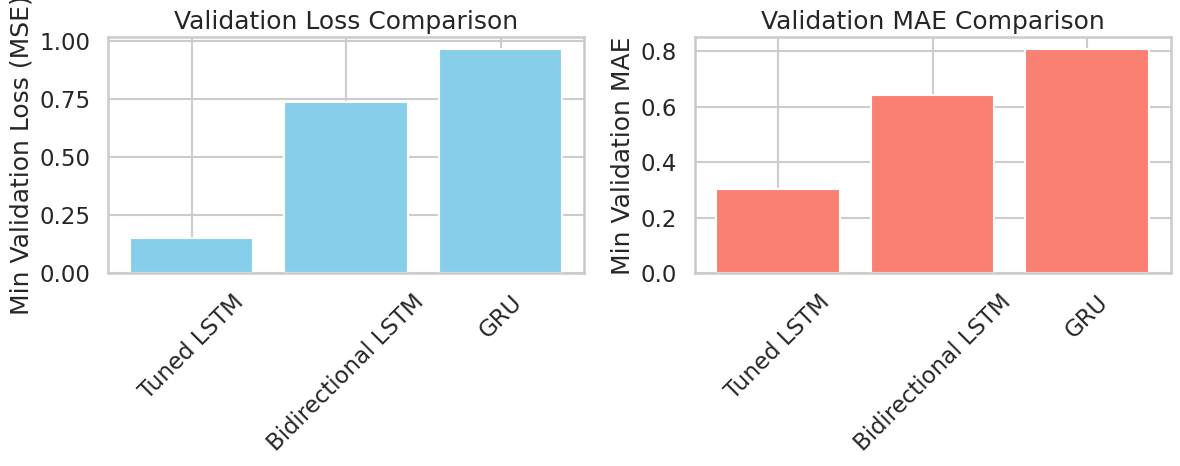

In [36]:
models = list(df_results.index)
val_loss = df_results["min_val_loss"].values
val_mae = df_results["min_val_mae"].values

plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.bar(models, val_loss, color='skyblue')
plt.ylabel("Min Validation Loss (MSE)")
plt.title("Validation Loss Comparison")
plt.xticks(rotation=45)

# Plot Validation MAE
plt.subplot(1, 2, 2)
plt.bar(models, val_mae, color='salmon')
plt.ylabel("Min Validation MAE")
plt.title("Validation MAE Comparison")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [16]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00


In [15]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00
